<a href="https://colab.research.google.com/github/R-802/LING-226-Assignments/blob/main/Assignment_One.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#LING226 2023 T3 Assignment One
- Shemaiah Rangitaawa `300601546`
- Attempting Challenge

**Note:** Due the computationally intensive nature of certain sections of this program it is useful to be in a GPU based runtime enviroment.

In [ ]:
import string
import nltk
from nltk.tokenize import word_tokenize

nltk.download('punkt', quiet=True)

def clean_text(text, stop_words=None, remove_punctuation=True, to_lowercase=True):
    if to_lowercase:
        text = text.lower()

    if remove_punctuation:
        text = text.translate(str.maketrans('', '', string.punctuation))

    # Tokenize the text
    words = word_tokenize(text)

    # Ensure stop_words is a set for efficiency
    stop_words_set = set(stop_words) if stop_words else set()

    # Filter out stop words
    filtered_words = [word for word in words if word not in stop_words_set]

    return ' '.join(filtered_words)

## **Text Preprocessing Using Term Frequency - Inverse Document Frequency (TF-IDF) Filtering**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

def preprocess_tf_idf(texts, stop_words, idf_percentile_lower=10, idf_percentile_upper=90):
    """
    Preprocess texts by calculating TF-IDF and filtering words based on TF-IDF percentile thresholds.

    :param texts: List of input texts to be preprocessed.
    :param stop_words: Words to be removed from the text.
    :param idf_percentile_lower: Lower percentile threshold for TF-IDF scores.
    :param idf_percentile_upper: Upper percentile threshold for TF-IDF scores.
    :return: List of preprocessed texts.
    """
    # Tokenize and clean each document
    clean_docs = [clean_text(text, stop_words) for text in texts]  # clean_text should return a string

    # Create a TF-IDF Vectorizer
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(clean_docs)

    # Get feature names and TF-IDF score
    feature_names = vectorizer.get_feature_names_out()
    tfidf_scores = np.asarray(tfidf_matrix.sum(axis=0)).flatten()

    # Calculate percentile thresholds
    lower_threshold = np.percentile(tfidf_scores, idf_percentile_lower)
    upper_threshold = np.percentile(tfidf_scores, idf_percentile_upper)

    # Filter words based on TF-IDF scores
    filtered_words = [feature_names[i] for i in range(len(feature_names))
                      if lower_threshold <= tfidf_scores[i] <= upper_threshold]

    # Reconstruct the documents using filtered words
    preprocessed_texts = []
    for doc in clean_docs:
        words = doc.split()
        preprocessed_texts.append(" ".join([word for word in words if word in filtered_words]))

    return preprocessed_texts

## **Text Preprocessing Using Context-based Filtering**
The fundamental idea behind this filtering approach is ensuring that text is processed in a manner that keeps the important information intact while getting rid of any distracting or unimportant elements. The goal is to maintain what matters most in the text and remove anything that doesn't contribute directly to the primary topic or objective of the text.

 It doesn't just rely on the frequency of terms but considers the relationships and meanings associated with those terms in their specific context. This preserves the nuanced and semantic information that can be lost in a simple term frequency analysis.

 Named entities, such as names of people, places, and organizations, are often important for understanding text content, this is useful. This approach also aims to preserve named entities, ensuring they are not mistakenly removed or altered during preprocessing.

In [ ]:
import torch
from transformers import BertTokenizer, BertModel

# Setting up the device for GPU usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loading the tokenizer and model
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name).to(device)

# Checking if CUDA is available and getting the GPU device name
cuda_available = torch.cuda.is_available()
gpu_name = torch.cuda.get_device_name(0) if cuda_available else "No CUDA Device Available"

cuda_available, gpu_name

(True, 'Tesla T4')

In [ ]:
# Function to create BERT embeddings
def create_embeddings(text, model=model, tokenizer=tokenizer, device='cuda'):
    inputs = tokenizer(text, padding=True, truncation=True, return_tensors="pt", max_length=512, add_special_tokens=True)
    inputs = {key: val.to(device) for key, val in inputs.items()}

    model.eval()

    with torch.no_grad():
        outputs = model(**inputs)

    hidden_states = outputs.last_hidden_state
    text_embedding = hidden_states.mean(dim=1).squeeze(0)

    return text_embedding

In [ ]:
import nltk
from nltk.tokenize import sent_tokenize
from nltk import ne_chunk
import torch.nn.functional as F

nltk.download('averaged_perceptron_tagger', quiet=True)
nltk.download('maxent_ne_chunker', quiet=True)
nltk.download('words', quiet=True)

# Main function to preprocess text
def preprocess(text, keyword_embeddings, stop_words, threshold=0.5):
    sentences = sent_tokenize(text)
    filtered_sentences = []

    for sentence in sentences:
        sentence_embedding = create_embeddings(sentence)
        similarities = [F.cosine_similarity(
                            sentence_embedding.unsqueeze(0),
                            keyword_emb.unsqueeze(0), dim=1)
                            for keyword_emb in keyword_embeddings]

        # Check if any similarity is above the threshold
        similarity_above_threshold = any(similarity > threshold for similarity in similarities)

        # Perform named entity recognition (NER) using NLTK
        words = nltk.word_tokenize(sentence)
        pos_tags = nltk.pos_tag(words)
        named_entities = nltk.ne_chunk(pos_tags)

        # Check if named entities are present
        named_entities_present = any(isinstance(chunk, nltk.Tree) and chunk.label() == 'NE' for chunk in named_entities)

        # If either similarity or named entities are present, retain the sentence
        if similarity_above_threshold or named_entities_present:
            filtered_sentences.append(sentence)

    processed_text = ' '.join(filtered_sentences)
    return clean_text(processed_text, stop_words)

### **Keyword Extraction**

In [ ]:
!pip install keybert
!pip install sentence_transformers

In [ ]:
from keybert import KeyBERT
import torch

# Initialize KeyBERT model
kw_model = KeyBERT()

def extract_keywords(text, num_keywords=5):
    """
    Extract keywords from a text using KeyBERT and compute their embeddings.

    :param text: The text to extract keywords from.
    :param num_keywords: Number of keywords to extract.
    :return: A dictionary with keyword embeddings and the list of keywords.
    """

    # Extract keywords from the text
    keywords = kw_model.extract_keywords(text, keyphrase_ngram_range=(1, 2), stop_words='english', top_n=num_keywords, use_mmr=True, diversity=0.7)

    # Extract just the keywords (first element of each tuple)
    extracted_keywords = [keyword[0] for keyword in keywords]

    # Tokenize and encode extracted keywords in a batch
    key_word_tokens = tokenizer(extracted_keywords, padding=True, return_tensors="pt").to(device)

    with torch.no_grad():
        key_word_outputs = model(**key_word_tokens)
    key_word_embeddings = key_word_outputs.last_hidden_state.mean(dim=1)

    return {
        'key_word_embeddings': key_word_embeddings,
        'keywords': extracted_keywords
    }

## **Text Metrics**

In [ ]:
import re
import nltk
from collections import Counter
from nltk.tokenize import sent_tokenize

def text_metrics(text):

    # Overall lexical diversity
    words = word_tokenize(text.lower())
    overall_lexical_diversity = lexical_diversity(words)
    num_words = len(words)

    # Sentence tokenization
    sentences = sent_tokenize(text)

    # Lexical diversity per sentence
    sentence_diversities = []
    for sentence in sentences:
        words_in_sentence = word_tokenize(sentence)
        unique_words = len(set(words_in_sentence))
        total_words = len(words_in_sentence)
        if total_words > 0:
            sentence_diversity = unique_words / total_words
        else:
            sentence_diversity = 0
        sentence_diversities.append(sentence_diversity)

    # Average lexical diversity of sentences
    avg_sentence_lexical_diversity = sum(sentence_diversities) / len(sentence_diversities) if sentence_diversities else 0

    # Top ten most frequent words
    top_ten_words = Counter(words).most_common(10)
    num_sentences = len(sentences)

    return {
        'num_words': num_words,
        'lexical_diversity': overall_lexical_diversity,
        'avg_sentence_lexical_diversity': avg_sentence_lexical_diversity,
        'top_ten_words': top_ten_words,
        'num_sentences': num_sentences
    }

In [ ]:
def lexical_diversity(words):
    """
    Calculate the overall lexical diversity of the text.

    :param words: List of all words in the text.
    :return: Lexical diversity, a ratio of unique words to total words.
    """
    return len(set(words)) / len(words) if words else 0

###**Formatting Function for Text Metrics**

In [ ]:
def format_metrics(titles, metrics_list):
    for title, metrics in zip(titles, metrics_list):
        if metrics['top_ten_words']:
            formatted_top_words = ', '.join([word for word, _ in metrics['top_ten_words']])
            highest_word, highest_freq = metrics['top_ten_words'][0]  # Extracting the highest frequency word and its frequency
        else:
            formatted_top_words = "None"
            highest_word, highest_freq = ("N/A", 0)

        # Formatting the diversities as percentages
        overall_diversity_percentage = metrics['lexical_diversity'] * 100
        avg_sentence_diversity_percentage = metrics['avg_sentence_lexical_diversity'] * 100

        print(f"--------- Text Metrics for {title} ---------")
        print(f"Total Words: {metrics['num_words']}")
        print(f"Total Sentences: {metrics['num_sentences']}")
        print(f"Overall Lexical Diversity: {overall_diversity_percentage:.2f}%")
        print(f"Average Lexical Diversity of Sentences: {avg_sentence_diversity_percentage:.2f}%")
        print(f"Top Ten Most Frequent Words: {formatted_top_words}")
        print(f"Highest Frequency Word: '{highest_word}' (Frequency: {highest_freq})")
        print()

# **Experimentation**
The following experimentation section includes:
- An analysis and overview of metrics from both sample texts.  
- Visualization of the top ten words before and after processing.
- Analysis of Emma's overall lexical diversity before and after processing.

**Notes:** I have chosen to use the NLTK's stopword list for preprocessing.

In [ ]:
# @title ##**Importing and Reading `TP001.txt`, `TP002.txt` from URL and `austen-emma.txt` from NLTK corpora** {display-mode: "form"}
# @markdown It is only reqired to run this cell once. This cell is dedicated to importing `TP001.txt`, `TP002.txt`, and `austen-emma.txt` for processing.The files are loaded and their initial contents are displayed. Spellcheck is then performed on `TP001.txt`, `TP002.txt`.
!wget 'https://raw.githubusercontent.com/scskalicky/LING-226-vuw/main/the-current/tp001.txt'
!wget 'https://raw.githubusercontent.com/scskalicky/LING-226-vuw/main/the-current/tp002.txt'
!pip install symspellpy

import pkg_resources
from nltk.corpus import gutenberg
from symspellpy import SymSpell, Verbosity

nltk.download('gutenberg', quiet=True)

def read_comments_from_file(filepath):
    with open(filepath, 'r', encoding='utf-8') as file:
        return " ".join(line.split('\t')[1].strip() for line in file if '\t' in line)

def spellcheck(text):
    # Initialize SymSpell
    symspell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
    dictionary_path = pkg_resources.resource_filename("symspellpy", "frequency_dictionary_en_82_765.txt")
    symspell.load_dictionary(dictionary_path, term_index=0, count_index=1)

    # Tokenize the input text
    words = text.split()
    corrected_text = []
    for word in words:
        # Get the best suggestion
        suggestions = symspell.lookup(word, Verbosity.CLOSEST, max_edit_distance=2)

        # Use the most likely suggestion, or the original word if no suggestion found
        if suggestions:
            corrected_word = suggestions[0].term
        else:
            corrected_word = word
        corrected_text.append(corrected_word)

    # Join the corrected words back into a string
    return ' '.join(corrected_text)

# Read and process the texts
tp001 = read_comments_from_file('tp001.txt')
tp002 = read_comments_from_file('tp002.txt')

# Using Emma by Jane Austen 1816
emma_text = gutenberg.raw('austen-emma.txt')

# Fix spelling
tp001_text = spellcheck(tp001)
tp002_text = spellcheck(tp002)

## **Importing Libraries and Initializing NLTK Stopwords**
I have also added some random words and characters that appeared during analysis and contributed little to the overall context of the texts.

In [ ]:
import nltk
from nltk.corpus import stopwords
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Using stopwords from NLTK
nltk.download('stopwords', quiet=True)
stop_words = set(stopwords.words('english'))

# Additional words to the stopwords set
additional_stopwords = {'n', 'mr', '1816', 'mrs', 'miss',  'ä', 'å', 'pä', 'n', 's', 'r', 'tä', 'wä', 'thä', 'bä', 'ahhhhhhhhhhhh', 'hxbdjs', 'aga', 've', 'fhdvb', 'vvvvv'}
stop_words.update(additional_stopwords)
print(stop_words)

{'ahhhhhhhhhhhh', 'isn', 'myself', 'once', 'we', 'but', 'having', 'those', 'a', 'at', 'yourselves', 'of', "you'll", 'from', 'over', "wouldn't", 'itself', 'has', 'other', 'be', 'were', 'who', 'ä', 'own', 'more', 'had', 'him', 'don', "needn't", 'very', 'shouldn', 'whom', "you're", "couldn't", 'haven', 'off', 'she', 'is', 'will', 'doing', 'until', 'to', 'r', "wasn't", 's', "didn't", 'theirs', 'as', 'by', 'just', 've', 'hasn', 'any', 'won', 'aga', "won't", 'before', 'after', "don't", 'while', 'nor', 'such', "you'd", 'further', 'mustn', 'between', 'in', 'with', "that'll", 'each', 'ourselves', 'because', 'ain', 'its', 'through', 'needn', 'hxbdjs', 'do', 'most', '1816', 'all', 'å', 'where', "mightn't", 'wasn', 'not', 'there', 'i', 'yours', 'an', "she's", 'was', 'than', 'when', 'hers', 'my', 'few', 'y', 'mightn', 'then', 'mr', 'or', 'doesn', 'bä', 'her', 'here', 'how', 'up', 'down', "it's", "shan't", "hadn't", 'if', 'for', 'about', 'd', 'into', 'did', "hasn't", 'below', 'both', 'now', 'himself

## **Analysis and Extraction of Key Metrics from Sample Texts**


###**Analyzing Raw Texts**

In [ ]:
# Get text metrics for raw unprocessed text
emma_metrics = text_metrics(emma_text)
tp001_metrics = text_metrics(tp001_text)
tp002_metrics = text_metrics(tp002_text)

# Prepare titles and metrics for the function
titles = ["Emma - Raw Text", "TP001 - Raw Text", "TP002 - Raw Text"]
metrics_list = [emma_metrics, tp001_metrics, tp002_metrics]

# Using the format_and_graph_multiple_metrics function to display metrics and graphs
format_metrics(titles, metrics_list)

--------- Text Metrics for Emma - Raw Text ---------
Total Words: 191781
Total Sentences: 7493
Overall Lexical Diversity: 4.14%
Average Lexical Diversity of Sentences: 90.89%
Top Ten Most Frequent Words: ,, ., the, to, and, of, i, a, --, it
Highest Frequency Word: ',' (Frequency: 12016)

--------- Text Metrics for TP001 - Raw Text ---------
Total Words: 39665
Total Sentences: 101
Overall Lexical Diversity: 9.48%
Average Lexical Diversity of Sentences: 55.89%
Top Ten Most Frequent Words: the, to, a, and, we, of, it, be, is, for
Highest Frequency Word: 'the' (Frequency: 1572)

--------- Text Metrics for TP002 - Raw Text ---------
Total Words: 149382
Total Sentences: 533
Overall Lexical Diversity: 5.53%
Average Lexical Diversity of Sentences: 63.23%
Top Ten Most Frequent Words: the, to, fish, a, we, and, it, of, is, #
Highest Frequency Word: 'the' (Frequency: 6065)



### **Analyzing Texts Processed with Context-Based Filtering**
This section is computationally and resource intensive, it can also take a while to run, typically under 4 minutes on a Tesla T4 in the colab runtime environment. It can be skipped.

In [ ]:
# Extracting keywords for preprocessing
num_tp001_keywords = 12 # @param {type:"slider", min:1, max:25, step:1}
tp001_keywords = extract_keywords(tp001_text, num_tp001_keywords)
print(tp001_keywords['keywords'])

num_tp002_keywords = 15 # @param {type:"slider", min:1, max:25, step:1}
tp002_keywords = extract_keywords(tp002_text, num_tp002_keywords)
print(tp002_keywords['keywords'])

num_emma_keywords = 20 # @param {type:"slider", min:1, max:50, step:1}
emma_keywords = extract_keywords(emma_text, num_emma_keywords)
print(emma_keywords['keywords'])

emma_keyword_embeddings = emma_keywords['key_word_embeddings']
tp001_keyword_embeddings = tp001_keywords['key_word_embeddings']
tp002_keyword_embeddings = tp002_keywords['key_word_embeddings']

['environment banning', 'revolutionary change', 'bikes instead', 'begin petrol', 'technologies support', 'diseases future', 'evaluate priorities', 'totally agree', 'pray lao', 'economical torque', 'cd minimum', 'exist charging', 'change saving', 'cell functional', 'dairy intake', 'number babyboomers', 'fhdvb vvvvv']
['fishing sustainability', 'force prices', 'agree ve', 'pie step', 'protecting keys', 'carbs eat', 'average kiwi', 'inortaibt environment', 'setters rest', 'discriminates people', 'mercury levels', 'create medicine', 'qms help', 'brush options', 'confirmed happens']
['emma circumstances', '1816 volume', 'governess mean', 'marriage poorer', 'sent mrs', 'father uneasy', 'woodhouses settled', 'bilious means', 'clemency hard', 'hartfield agreeable', 'write book', 'taste valued', 'connexion dependent', 'difference randalls', 'increasing coldness', 'continue error', 'rendered protecting', 'device flatter', 'point smallest', 'venture salary']


In [ ]:
# Preprocess TP001 text
preprocessed_tp001 = preprocess(tp001_text, tp001_keyword_embeddings, stop_words)
preprocessed_tp001_metrics = text_metrics(preprocessed_tp001)
format_metrics(["TP001 - Context-based Preprocessing"], [preprocessed_tp001_metrics])

# Preprocess TP002 text
preprocessed_tp002 = preprocess(tp002_text, tp002_keyword_embeddings, stop_words)
preprocessed_tp002_metrics = text_metrics(preprocessed_tp002)
format_metrics(["TP002 - Context-based Preprocessing"], [preprocessed_tp002_metrics])

# Preprocess Emma text
preprocessed_emma = preprocess(emma_text, emma_keyword_embeddings, stop_words)
preprocessed_emma_metrics = text_metrics(preprocessed_emma)
format_metrics(["Emma - Context-based Preprocessing"], [preprocessed_emma_metrics])

--------- Text Metrics for TP001 - Preprocessed Text ---------
Total Words: 6788
Total Sentences: 1
Overall Lexical Diversity: 30.17%
Average Lexical Diversity of Sentences: 30.17%
Top Ten Most Frequent Words: cars, petrol, think, environment, need, people, electric, change, better, would
Highest Frequency Word: 'cars' (Frequency: 216)

--------- Text Metrics for TP002 - Preprocessed Text ---------
Total Words: 2411
Total Sentences: 1
Overall Lexical Diversity: 45.33%
Average Lexical Diversity of Sentences: 45.33%
Top Ten Most Frequent Words: fish, need, think, eat, people, sustainable, future, better, would, environment
Highest Frequency Word: 'fish' (Frequency: 141)

--------- Text Metrics for Emma - Preprocessed Text ---------
Total Words: 24908
Total Sentences: 1
Overall Lexical Diversity: 21.89%
Average Lexical Diversity of Sentences: 21.89%
Top Ten Most Frequent Words: would, could, emma, must, every, harriet, one, think, said, never
Highest Frequency Word: 'would' (Frequency: 29

###**Analyzing Preprocessed Texts Using TF-IDF Based Filtering**

In [ ]:
# Preprocess the texts using TF-IDF
texts = [tp001_text, tp002_text, emma_text]
preprocessed_texts = preprocess_tf_idf(texts, stop_words)
tf_idf_tp001 = preprocessed_texts[0]
tf_idf_tp002 = preprocessed_texts[1]
tf_idf_emma = preprocessed_texts[2]

# Calculate metrics for each preprocessed text
tf_idf_tp001_metrics = text_metrics(tf_idf_tp001)
tf_idf_tp002_metrics = text_metrics(tf_idf_tp002)
tf_idf_emma_metrics = text_metrics(tf_idf_emma)

# Display formatted metrics
titles_tf_idf = ["TP001 - TF-IDF Preprocessed Text", "TP002 - TF-IDF Preprocessed Text", "Emma - TF-IDF Preprocessed Text"]
metrics_tf_idf = [tf_idf_tp001_metrics, tf_idf_tp002_metrics, tf_idf_emma_metrics]
format_metrics(titles_tf_idf, metrics_tf_idf)

--------- Text Metrics for TP001 - TF-IDF Preprocessed Text ---------
Total Words: 3630
Total Sentences: 1
Overall Lexical Diversity: 69.78%
Average Lexical Diversity of Sentences: 69.78%
Top Ten Most Frequent Words: tax, output, contributor, lazy, asap, economical, cities, relying, generated, classic
Highest Frequency Word: 'tax' (Frequency: 7)

--------- Text Metrics for TP002 - TF-IDF Preprocessed Text ---------
Total Words: 13441
Total Sentences: 1
Overall Lexical Diversity: 49.20%
Average Lexical Diversity of Sentences: 49.20%
Top Ten Most Frequent Words: feed, treat, preserving, museum, mindful, decisions, top, sustained, choose, thriving
Highest Frequency Word: 'feed' (Frequency: 27)

--------- Text Metrics for Emma - TF-IDF Preprocessed Text ---------
Total Words: 17730
Total Sentences: 1
Overall Lexical Diversity: 44.53%
Average Lexical Diversity of Sentences: 44.53%
Top Ten Most Frequent Words: refuse, neighbours, expectation, mistake, evidently, blind, express, paper, habit,

NameError: ignored

## **Top Ten Words Before and After Processing**

The graphs below presents a comparison of the top ten most frequent words from three different texts under three different conditions: raw frequency (no preprocessing), after context-based preprocessing, and after TF-IDF preprocessing.

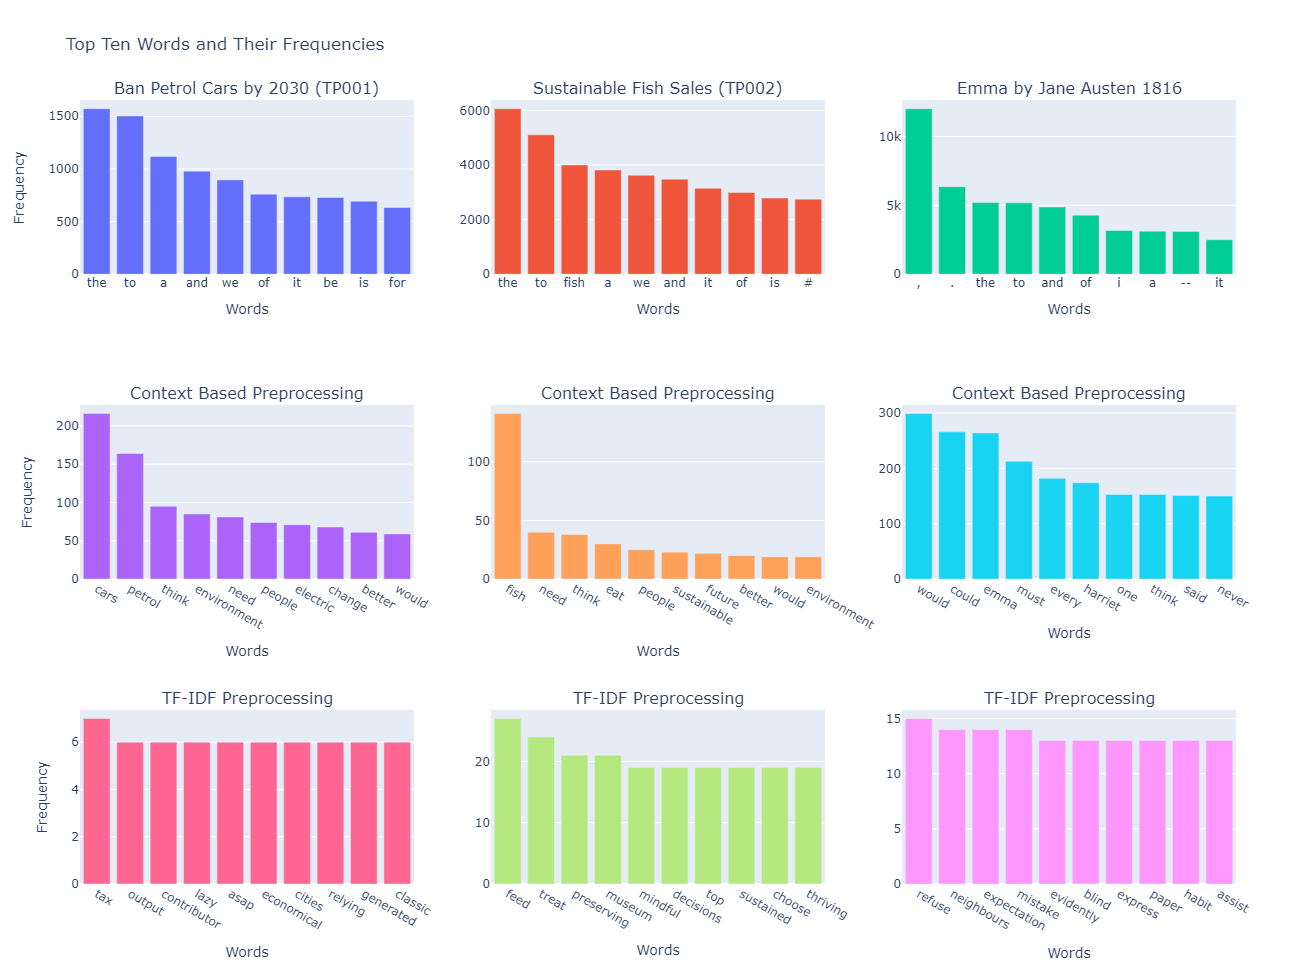

From the raw frequency graphs at the top, we see that common stopwords like "the", "to", "and", "of" dominate in all texts. This is typical in unprocessed texts, as such function words are necessary for grammatical structure but carry little unique meaning.

After context-based preprocessing, which includes stopword removal and lowercasing, the graphs show a drastic change. The most frequent words now appear to be more topical and content-specific, such as "cars", "electric", and "environment" for TP001, and "fish", "sustainable", and "future" for TP002. This suggests that the context-based preprocessing has effectively removed the noise of common words, bringing content-specific terms to the forefront.

For Emma by Jane Austen, even after context-based preprocessing, some common words like "would" and "could" remain frequent, possibly indicating their importance in the narrative style of the era, the author or in this specific text.

The TF-IDF preprocessing further refines the word frequencies by considering the importance of words across multiple documents. The words that remain after TF-IDF preprocessing have lower frequencies than the unprocessed and context-processed lists, but they're weighted to be more significant within the context of their respective documents. Words like "tax", "output", and "combustion" for TP001 and "feed", "treat", "thriving" for TP002 suggest that TF-IDF has brought out terms which are not just common in the individual text but also distinct compared to others in the corpus. This implies that these words are particularly descriptive or relevant to the subject matter of the text.

For Emma, we see words like "refuse", "express", and "neighbors" which point to key themes and elements of the plot unique within the context of its corpus.

####**Effects of Processing Approaches on The Top Ten Words:**
**Context-Based Preprocessing:**
- Leaves words that are more relevant to the specific context of each text, allowing for a clearer view of the main themes and subjects.
- Can still include common words that are not stopwords but occur frequently across different texts and may not be contextually unique.

**TF-IDF Preprocessing:**
- Goes a step further by scoring words based on their distinctiveness across the corpus.
- Brings forward the words that are potentially the most defining for each text, even if they aren't the most frequent.
- Can reveal the underlying themes and topics of a text that might be overlooked with simple frequency counts.

####**Trends and Observations:**
- **Stopword Prevalence in Raw Text:** Initially, stopwords dominate the list of frequent words and the effects of processing become clear as words that show the content of the text are revealed.
- **Content Relevance in Preprocessed Text:** After context-based preprocessing, the words that remain are more content-specific, suggesting a significant removal of common words that don't contribute to the unique meaning of the text.
- **Uniqueness Highlighted by TF-IDF:** TF-IDF seems to show a much lower frequency range, suggesting that these words, while critical, appear less frequently than common stopwords. This also implies that TF-IDF is effective at identifying words that are important within a specific document but less common in the language as a whole.

In [ ]:
#@title ##Graph Generation Code {display-mode: "form"}
# Extracting top ten words and their frequencies for plotting
tp001_top_ten_words, tp001_frequencies = zip(*tp001_metrics['top_ten_words'])
tp002_top_ten_words, tp002_frequencies = zip(*tp002_metrics['top_ten_words'])
emma_top_ten_words, emma_frequencies = zip(*emma_metrics['top_ten_words'])

preprocessed_tp001_top_ten, preprocessed_tp001_freq = zip(*preprocessed_tp001_metrics['top_ten_words'])
preprocessed_tp002_top_ten, preprocessed_tp002_freq = zip(*preprocessed_tp002_metrics['top_ten_words'])
preprocessed_emma_top_ten, preprocessed_emma_freq = zip(*preprocessed_emma_metrics['top_ten_words'])

tf_idf_tp001_top_ten, tf_idf_tp001_freq = zip(*tf_idf_tp001_metrics['top_ten_words'])
tf_idf_tp002_top_ten, tf_idf_tp002_freq = zip(*tf_idf_tp002_metrics['top_ten_words'])
tf_idf_emma_top_ten, tf_idf_emma_freq = zip(*tf_idf_emma_metrics['top_ten_words'])

# Create a subplot figure with 3 rows and 3 columns (transposed)
fig = make_subplots(
    rows=3, cols=3,
    subplot_titles=(
        'Ban Petrol Cars by 2030 (TP001)',
        'Sustainable Fish Sales (TP002)',
        'Emma by Jane Austen 1816',
        'Context Based Preprocessing',
        'Context Based Preprocessing',
        'Context Based Preprocessing',
        'TF-IDF Preprocessing',
        'TF-IDF Preprocessing',
        'TF-IDF Preprocessing')
)

# Original TP001
fig.add_trace(
    go.Bar(x=tp001_top_ten_words, y=tp001_frequencies),
    row=1, col=1
)

# Original TP002
fig.add_trace(
    go.Bar(x=tp002_top_ten_words, y=tp002_frequencies),
    row=1, col=2
)

# Original Emma
fig.add_trace(
    go.Bar(x=emma_top_ten_words, y=emma_frequencies),
    row=1, col=3
)

# Preprocessed TP001
fig.add_trace(
    go.Bar(x=preprocessed_tp001_top_ten, y=preprocessed_tp001_freq),
    row=2, col=1
)

# Preprocessed TP002
fig.add_trace(
    go.Bar(x=preprocessed_tp002_top_ten, y=preprocessed_tp002_freq),
    row=2, col=2
)

# Preprocessed Emma
fig.add_trace(
    go.Bar(x=preprocessed_emma_top_ten, y=preprocessed_emma_freq),
    row=2, col=3
)

# TF-IDF TP001
fig.add_trace(
    go.Bar(x=tf_idf_tp001_top_ten, y=tf_idf_tp001_freq),
    row=3, col=1
)

# TF-IDF TP002
fig.add_trace(
    go.Bar(x=tf_idf_tp002_top_ten, y=tf_idf_tp002_freq),
    row=3, col=2
)

# TF-IDF Emma
fig.add_trace(
    go.Bar(x=tf_idf_emma_top_ten, y=tf_idf_emma_freq),
    row=3, col=3
)

# Update layout
fig.update_layout(
    title_text='Top Ten Words and Their Frequencies',
    showlegend=False,
    height=970
)

# Customize axis labels
for row in range(1, 4):
    for col in range(1, 4):
        fig.update_xaxes(title_text='Words', row=row, col=col)

fig.update_yaxes(title_text='Frequency', row=1, col=1)
fig.update_yaxes(title_text='Frequency', row=2, col=1)
fig.update_yaxes(title_text='Frequency', row=3, col=1)

# Show the figure
fig.show()

## **Comparative Analysis of Overall Lexical Diversity in Processed and Unprocessed Versions of Emma**

The results of the analysis below show the overall lexical diversity of Jane Austen's "Emma" in both its processed and unprocessed forms as the batch size (number of sentences per batch) increases. It demonstrates how lexical diversity decreases as the size of the text increases.

**Processed Overall Lexical Diversity (Blue):** As the batch size increases, we observe a gradual decrease in lexical diversity for the processed version. This trend indicates that when analyzing larger portions of the text together, the processed version becomes less lexically diverse. This is attributed to the removal of high-frequency and stop words during processing, which results in a more focused vocabulary.

**Unprocessed Overall Lexical Diversity (Red):** The red line represents the lexical diversity of the original, unprocessed text. In this case, as the batch size increases, we see a sharp decrease in lexical diversity of the unprocessed text. This decrease suggests that even in the unprocessed text, certain words become more prominent and repetitive when analyzing larger sections of the text.

In summary, overall lexical diversity highlights how text processing affects the diversity of words in a text, particularly as the of a text scale increases. While both processed and unprocessed texts exhibit a decrease in lexical diversity with larger batch sizes, the unprocessed version tends to show a more pronounced decrease due to the inherent diversity in this large text.

In [ ]:
increment = 10  # n sentences per increment
emma_num_sentences = emma_metrics['num_sentences']
batch_sizes = list(range(1, emma_num_sentences, increment))  # Incrementally increase batch size

ld_unprocessed = []
ld_processed = []

sentences = sent_tokenize(emma_text)
cleaned_sentences = [clean_text(sentence, stop_words) for sentence in sentences]

# Calculate lexical diversities
for batch_size in batch_sizes:
    unprocessed_batch = ' '.join(sentences[:batch_size])
    processed_batch = ' '.join(cleaned_sentences[:batch_size])

    unprocessed_words = unprocessed_batch.lower().split()
    processed_words = processed_batch.lower().split()

    unprocessed_diversity = lexical_diversity(unprocessed_words)
    processed_diversity = lexical_diversity(processed_words)

    ld_unprocessed.append(unprocessed_diversity)
    ld_processed.append(processed_diversity)

In [ ]:
# Prepare batch size labels with sentence count
batch_size_labels = [batch_size for batch_size in batch_sizes]

# Convert lexical diversity to percentages
processed_lex_div = [ld * 100 for ld in ld_processed]
unprocessed_lex_div = [ld * 100 for ld in ld_unprocessed]

# Create traces
trace1 = go.Scatter(
    x=batch_size_labels,
    y=processed_lex_div,
    mode='lines',
    name='Overall Lexical Diversity (Processed)',
)
trace2 = go.Scatter(
    x=batch_size_labels,
    y=unprocessed_lex_div,
    mode='lines',
    name='Overall Lexical Diversity (Unprocessed)',
)

# Layout
layout = go.Layout(
    title='Overall Lexical Diversity over Increments of ' + str(increment) + ' Sentences',
    xaxis=dict(title='Number of Sentences'),
    yaxis=dict(title='Lexical Diversity (%)'),
)

# Figure
fig = go.Figure(data=[trace1, trace2], layout=layout)

# Show plot
fig.show()